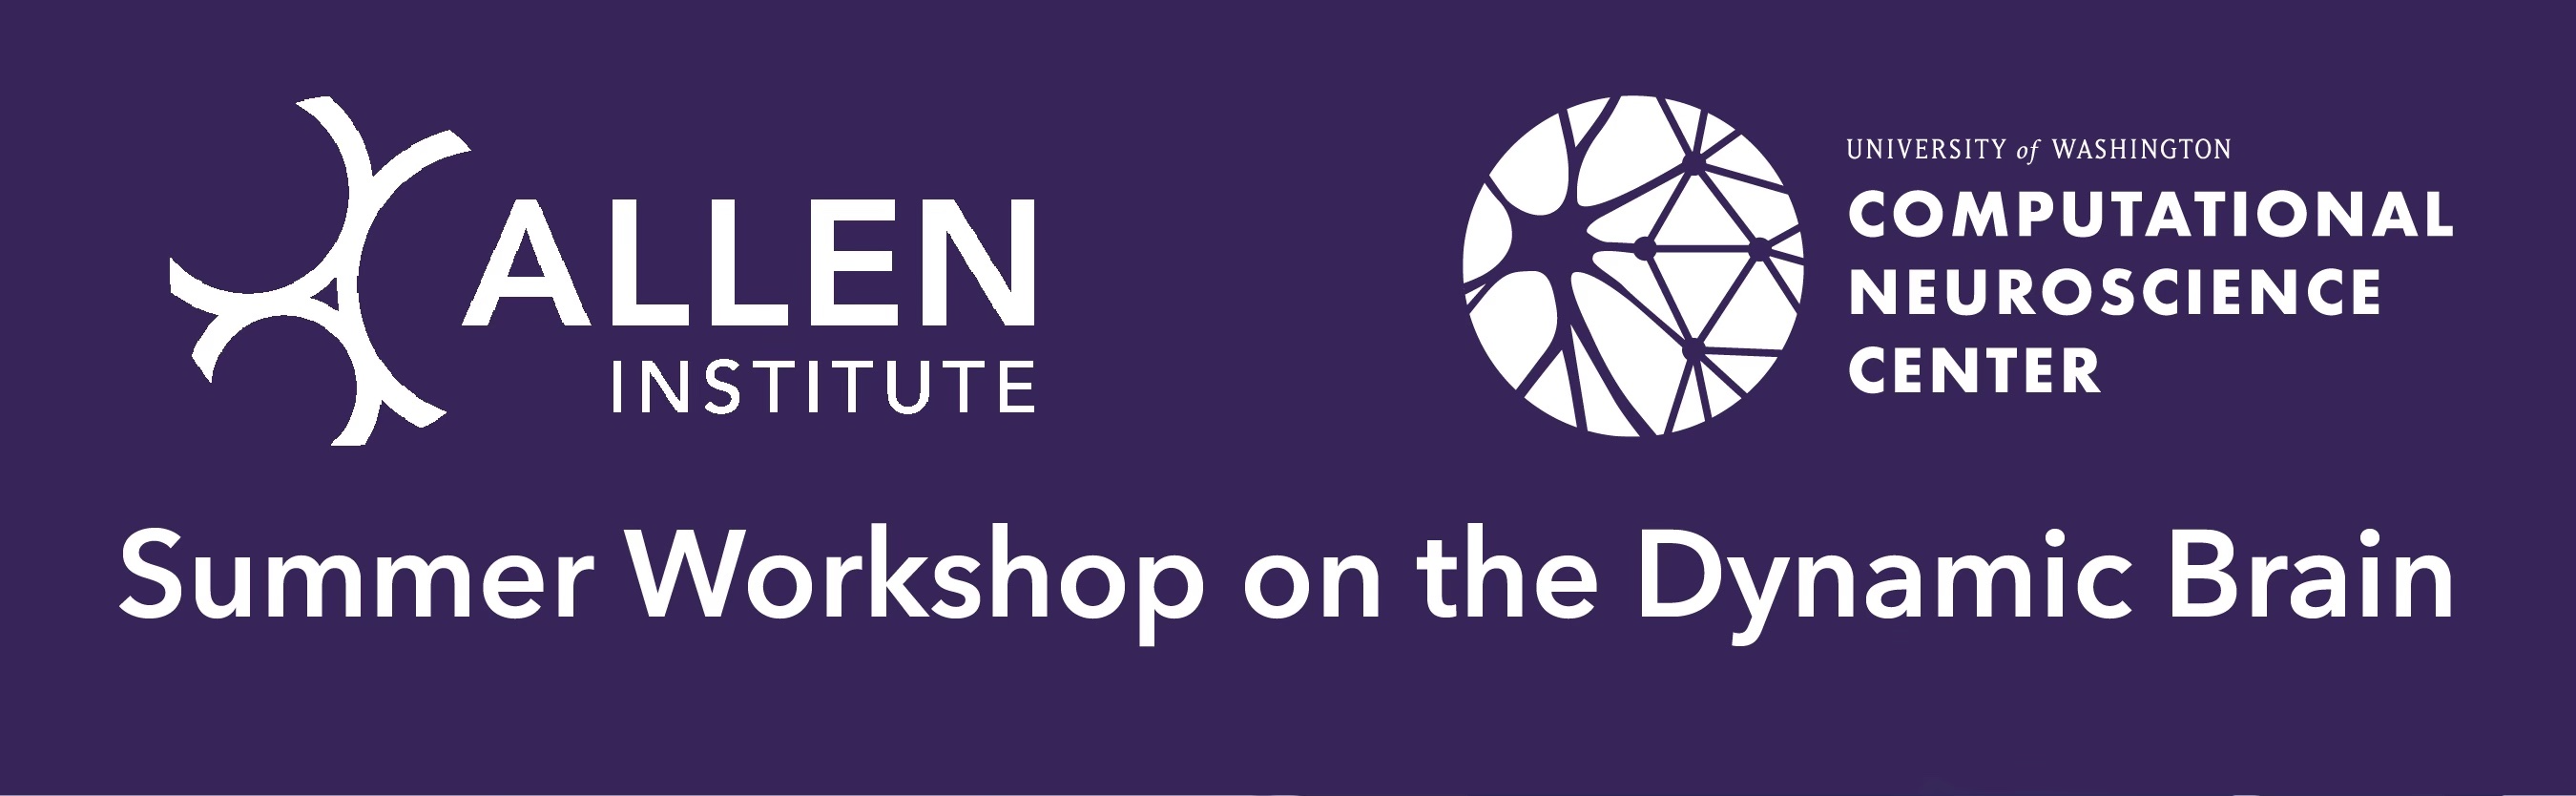

<h1 align="center">Day 1 Workshop 2: Science Quest</h1>  
<h2 align="center"> How do neuron interactions change after learning? </h4>   
<h2 align="center"> SWDB 2025</h2> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<h2>Goal</h2>
    
In this workshop, we will use our data access skills and dataset knowledge to ask a specific question: 

<b>How do neuron interactions change after learning?</b>
   
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
How should we go about addressing this question? 
    
#### <b> Step 1: </b>Which datasets have we learned about that would be useful to address this question? 
    
We will want a dataset with a behavior task where the mouse has to learn something, and we will want there to be a period of time before and after learning that we can use to compare activity to see if it changes. 
    
Let's look at our [SWDB Dataset Features Spreadsheet](https://docs.google.com/spreadsheets/d/1zwqS97x81jEVUUMTLLtlk6NMMR2C7DhY9nJDB2BLvBE/edit?usp=sharing) and find a dataset with a behavior task and spontaneous activity periods pre and post task learning. 
    
We can use... the BCI learning dataset! 
    
<b>Why use this dataset?</b> In this dataset, mice learn to control the activity of a neuron in the motor cortex in order to receive rewards using a brain computer interface (BCI) paradigm. The activity of the conditioned neuron is read out in real time and is linked to the movement of a reward spot. Over a few trials, the activity of the conditioned neuron becomes coupled to the movement of the spout and the mouse "learns" to activate that neuron to move the spout towards them to get rewards. In contrast to other behavior tasks, this task enables us to study how learning of a single neuron can affect other cells in the network. 
    
#### <b> Step 2: </b>What analysis method can we use to address this question? 
    
One simple way to see if neurons could be interacting is to quantify how correlated their activity patterns are. If neurons are consistently co-active, they may be connected or receive shared input as part of an interacting circuit. 
        
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Let's use our new data access skills to load the BCI data and compare neuron activity correlations during the spontaneous periods before and after a mouse learns the BCI task!

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2>Outline:</h2>
    
<h4>Part 1: Accessing the BCI data</h4> 
    - Metadata table & pynwb data acces

    
<h4>Part 2: What are the conditions in this dataset? </h4>
    - Epochs and Trials

<h4>Part 3: Quantifying activity correlations before and after BCI learning</h4>
    - Cell activity traces, selecting epochs of interest, computing correlations

<h4>Part 4: Do correlations depend on distance between neurons?</h4>
    - Segmented ROI masks and spatial relationships
<h4>   </h4>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>BCI dataset overview </h2> 
    
**Overview:** In this notebook, we will analyze neural activity changes 
before and after learning using a dataset from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) 
project at the Allen Institute for Neural Dynamics. This dataset provides a unique window 
into how cortical circuits adapt as mice learn to volitionally control a brain-computer interface (BCI) 
using single neurons in motor cortex. This tutorial focuses on population activity and event-aligned responses
in one experimental paradigm, multi-day learning, longitudinal connectivity mapping, 
and causal perturbations across many animals.
 
**Dataset:** 
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex 
of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days
 as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected, 
 the activity of this neuron was mapped in real-time to the position of a motorized reward port. 
 To receive water rewards, mice had to learn to increase the activity of the CN to move the port into reach.
The dataset also includes simultaneous photostimulation and calcium imaging sessions, in which individual or 
groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network. 
These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed.
 Imaging data were preprocessed using Suite2p and include motion-corrected fluorescence traces, 
 extracted ROIs, inferred spiking events, and stimulus-aligned behavioral metadata. 
 All data are registered across days to track the same neurons longitudinally.

 **Experiment:**
 This experiment was designed to test competing models of learning rules—such as Hebbian learning, 
 long-range input modulation, and biologically plausible approximations of error backpropagation—by 
 directly measuring changes in neural activity and inferred connectivity during learning. 
 The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled 
 a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter,
  this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the CN) versus merely correlated.
To probe learning-related circuit changes, cellular-resolution two-photon photostimulation
 was used to perturb neurons before and after learning. By analyzing evoked responses, 
 researchers could infer the presence and strength of functional connections. 
 Learning-induced changes in connectivity were then compared to predictions 
 from recurrent neural network models trained with different plasticity rules, 
 enabling discrimination between competing learning algorithms.



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [1]:
# General imports 
import os 
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 1: Accessing the BCI data</h2>   

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The 'metadata.csv' in the '/data' folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number   |

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the metadata csv file as a pandas dataframe. What are the column values? 

</div>

In [2]:
metadata = pd.read_csv('/data/metadata.csv')
metadata.head()

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,97679401-4b42-4cf9-9460-7b78a86d141c,single-plane-ophys_767715_2025-01-31_18-15-21_...,767715,2025-01-31T18:15:21.158999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_01,2.0
1,21e64498-ae4b-4c84-b22f-ba454068311b,single-plane-ophys_740369_2025-02-03_19-18-31_...,740369,2025-02-03T19:18:31.580999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_06,27.0
2,069e10c0-6d10-4101-bc33-f3febf0a6565,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0
3,6fcad999-aa85-439b-a51c-4cf844ca11d2,single-plane-ophys_740369_2025-01-24_21-18-11_...,740369,2025-01-24T20:08:49.286000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,25.0
4,b46c42e9-b7cc-4a1e-832d-9721816c9bc5,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0


In [3]:
metadata.columns

Index(['_id', 'name', 'subject_id', 'session_time', 'session_type', 'genotype',
       'virus_injection_materials', 'ophys_fov', 'session_number'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

What are the unique values for `genotype`? What aspects of the genotype might be useful for this experiment?

</div>

In [4]:
metadata.genotype.unique()

array(['Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt'],
      dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Sort the dataframe by `subject_id` and `session_time` to group experiments from the same mice and put them in chronological order. 
    
Hint: Make sure to reset the index after sorting the dataframe.

</div>

In [5]:
# Sort values by name and reindex 
metadata = metadata.sort_values(by = ['subject_id', 'session_time']).reset_index(drop = True)
metadata.head()

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,4fcfc173-452d-4d5b-b441-7b26da3d781b,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,20.0
1,b46c42e9-b7cc-4a1e-832d-9721816c9bc5,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
2,1f1039a9-72a2-4dd0-880b-2fe06c64e96a,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
3,b2497fb0-0e67-4c9a-b543-76ccc2c7fdbd,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,23.0
4,069e10c0-6d10-4101-bc33-f3febf0a6565,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's select a mouse and session to look at


In [6]:
# Pick the first mouse
subject_id = metadata['subject_id'].unique()[0]
# Save just the year, month, and date for the 3rd session from this mouse
date = metadata[metadata['subject_id']==subject_id].session_time[3][0:10] 
print('mouse_id:',subject_id, 'date:', date)

mouse_id: 731015 date: 2025-01-31


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the NWB file for this session using pynwb and examine its contents
    
Hint: Use `NWBZarrIO`

</div>

In [7]:
# First go through all the datasets in this capsule and find the folder that has our mouse's subject_id in the folder name
data_folder = [folder for folder in os.listdir(r'/data/') if str(subject_id) in folder and str(date) in folder][0]

# Set the directory to load the file
data_dir = os.path.join(r'/data/', data_folder)

# Now find the NWB file and set the path to load it
nwb_file = [file for file in os.listdir(data_dir) if 'nwb' in file][0]
nwb_path = os.path.join(data_dir, nwb_file)

In [8]:
with NWBZarrIO(str(nwb_path), 'r') as io:
    nwbfile = io.read()
    print('Loaded NWB file from:', nwb_path)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-07-23_02-28-40/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### NWB files

As you'll recall from workshop 1, NWB files are a standardized file format for systems neuroscience experiments. They are formatted similarly to hdf5 containers, with data stored using using a directory format. There are "containers" (i.e. directories) for each type of data.  

The key types of data in an NWB file are: 
* metadata (subject information, recording methodology, devices used, etc.)
* events (stimulus tables, discrete task epochs, etc.)
* processed data (cell traces, segmented ROI masks, etc.)
    
The data in each container are typically provided as dynamic tables or as matrices. 


In [9]:
nwbfile

root pynwb.file.NWBFile at 0x140000933936192
Fields:
  devices: {
    442_Bergamo_2p_photostim <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2025, 7, 22, 19, 36, 52, 330369, tzinfo=tzutc())]
  identifier: b02606e9-cd4d-467c-b780-60999e7a3115
  imaging_planes: {
    processed <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Neural Dynamics
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    processed <class 'pynwb.base.ProcessingModule'>
  }
  session_description: NWB file generated by AIND pipeline
  session_id: single-plane-ophys_731015_2025-01-31_20-37-19
  session_start_time: 2025-01-31 20:37:19-08:00
  stimulus: {
    PhotostimTrials <class 'hdmf.common.table.DynamicTable'>,
    Trials <class 'hdmf.common.table.DynamicTable'>
  }
  subject: subject pynwb.file.Subject at 0x140000933932400
Fields:
  age: P323D
  age__reference: birth
  date_of_birth: 2024-03-14 00:00:00-07:53
  genotype: Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt
  sex: F
  species: Mus musculus
  subject_id: 731015

  timestamps_reference_time: 2025-01-31 20:37:19-08:00

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [10]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Containers are accessed via dot (.) notation. If the data within the container are strings, they can also be accesed with dot notation. Like this: 

In [11]:
nwbfile.subject.genotype

'Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

If the data within a container is an object (another container, tables, or matrices), it can be accessed like items in a dictionary. Like this: 


In [12]:
nwbfile.devices['442_Bergamo_2p_photostim']

442_Bergamo_2p_photostim pynwb.device.Device at 0x139697316725280
Fields:
  description: Bergamo_2p-photostim-room442_20241021
  manufacturer: Thorlabs

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 2: What are the conditions in this dataset? </h2>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
The epochs table contains the start and stop times/frames for each experimental epoch. This tells you what types of conditions there are in the experiment.


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the `epochs` table from the *<b>intervals</b>* container of the NWB file. What epochs are present?
    
Hint: Make sure to turn the data into a dataframe to view it.

</div>

In [13]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_again,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spontpost,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Load the `dff_traces` from the *<b>processing</b>* container of the NWB file. What are the rows and columns? 
    
</div>

In [14]:
dff_traces = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape (nframes, nrois):',np.shape(dff_traces))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape (nframes, nrois): (249370, 1736)
Frame Rate: 58.2634


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Plot the dFF trace for ROI = 100 with the stimulus epochs overlaid in color. Does it's activity change across epochs?
    
</div>

/tmp/ipykernel_17220/1046110376.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Paired')


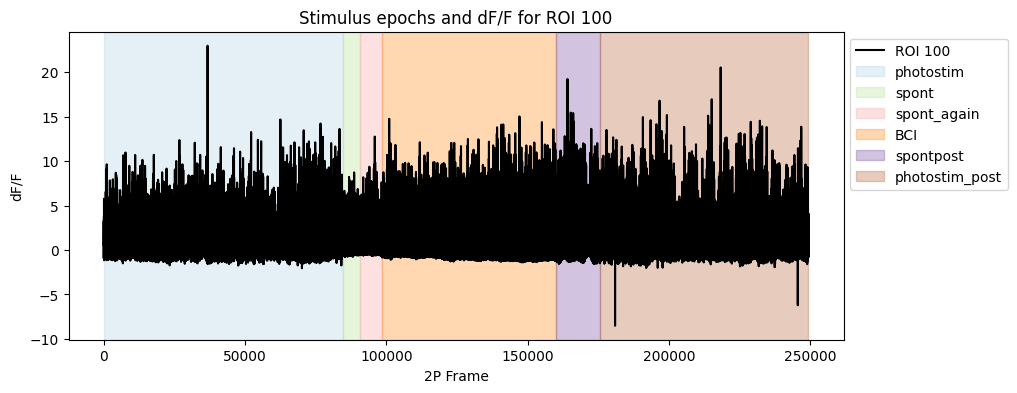

In [15]:
# Pick an ROI
ROI = 100

# Plot dff trace for selected ROI 
plt.rcParams["figure.figsize"] = (10, 4)
plt.plot(dff_traces[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 

stimulus_names = epoch_table.stimulus_name.unique()

import matplotlib.cm as cm
colors = cm.get_cmap('Paired')
colors = colors(np.linspace(0, 1, len(stimulus_names)))

                
for c, stimulus_name in enumerate(stimulus_names):
    stim_epoch = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim_epoch)):
        plt.axvspan(xmin=stim_epoch.start_frame.iloc[j], xmax=stim_epoch.stop_frame.iloc[j], color=colors[c], alpha=0.3, label=stimulus_name)

plt.ylabel('dF/F')
plt.xlabel('2P Frame')
plt.title('Stimulus epochs and dF/F for ROI '+str(ROI))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Stimulus and trials tables
 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What types of stimulus tables are available? Check the keys of the *<b>stimulus</b>* container.
    
Does every epoch have a corresponding stimulus table? 

</div>

In [16]:
nwbfile.stimulus.keys()

dict_keys(['PhotostimTrials', 'Trials'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Stimulus table (2p optogenetic activation stimulus) 
    
The stimulus table contains information about each 2p optogenetic stimulation trial. Optogenetic stimulation is used in this experiment to probe connectivity between neurons. In each trial, one neuron is stimulated, and all other neurons are recorded. Neurons with short latency responses after the optostim can be considered to be connected. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What stimuli are delivered during the photostim epoch? 
    
Load the `PhotostimTrials` table from the *<b>stimulus</b>* container and turn it into a dataframe, then check the columns. 

</div>

In [17]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()


,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.583557,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,15,85


In [18]:
photostim.columns


Index(['start_time', 'stop_time', 'start_frame', 'stop_frame', 'tiff_file',
       'stimulus_name', 'laser_x', 'laser_y', 'power', 'duration',
       'stimulus_function', 'group_index', 'closest_roi'],
      dtype='object')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    
What are the values of the `stimulus_name` column? 

</div>

In [19]:
photostim['stimulus_name'].unique()

array(['photostim', 'photostim_post'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation epochs - one before and one after the BCI epoch.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Here is what the columns mean:

| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stimulus_name    | stimulus name   |
| laser_x    | x coordinate of stimulated neuron (pixel)   |
| laser_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)   |
| closest_roi    | index in dff that corresponds to the photostimulated neuron   |


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI Behavior Table 
    
The behavior trials table contains information about what the mouse did during each trial, such as whether it licked or got a reward, and when in the trial these events happened. It also includes the ID of the conditioned neuron. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** What happens during the BCI task epoch? 
    
Load the `Trials` table from the *<b>stimulus</b>* container, turn it into a dataframe, then check the columns. 

</div>

In [20]:
trials = nwbfile.stimulus["Trials"].to_dataframe()
trials.head()


,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


In [21]:
trials.columns

Index(['start_time', 'stop_time', 'go_cue', 'hit', 'lick_L', 'reward_time',
       'threshold_crossing_times', 'zaber_step_times', 'tiff_file',
       'start_frame', 'stop_frame', 'conditioned_neuron_x',
       'conditioned_neuron_y', 'closest_roi'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Here is what the columns mean:

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | position of reward port  |
| tiff_file    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the photostimulated neuron  |


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Could the learning that happens during the BCI task epoch change the activity of the other neurons in the imaging plane? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 3: Quantifying activity correlations before and after BCI learning</h2>
    - Cell activity traces, selecting time periods of interest, computing correlations
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can quantify correlations during the spontaneous activity periods before and after BCI learning to see if neuronal interactions have changed as a result of learning. 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Extract cell activity during spontaneous activity epochs. 
    
First get the start and end frames of the spontaneous activity epochs before and after the BCI task. Include both `spont` and `spont_again` epochs for spontaneous activity before the task, so that it is a similar time frame as the `spontpost` epoch (~250 seconds)
    
</div>

In [22]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_again,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spontpost,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


In [23]:
spontaneous_pre = epoch_table[epoch_table.stimulus_name=='spont']
spontaneous_pre_again = epoch_table[epoch_table.stimulus_name=='spont_again']
spontaneous_post = epoch_table[epoch_table.stimulus_name=='spontpost']

In [24]:
spontaneous_pre.start_frame.values[0]

np.int64(84795)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Now get the dF/F traces limited to the spontaneous epochs. Create one new array for each epoch (pre and post). 
    
Transpose the array so that the rows are cell_ids and columns are 2P frames. 

</div>

In [25]:
dff_pre = dff_traces[spontaneous_pre.start_frame.values[0]:spontaneous_pre_again.stop_frame.values[0], :].T
dff_pre.shape

(1736, 13799)

In [26]:
dff_post = dff_traces[spontaneous_post.start_frame.values[0]:spontaneous_post.stop_frame.values[0], :].T
dff_post.shape

(1736, 15528)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Visualize the dFF traces for each spontaneous period as a heatmap. Make sure the x-axis is 2P frames and the y-axis is # ROIs.
    
Hint: use [pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html) to plot, it makes nicer heatmaps than imshow and interprets the axes nicely (but takes a bit longer).

</div>

Text(0.5, 1.0, 'Spontaneous pre')

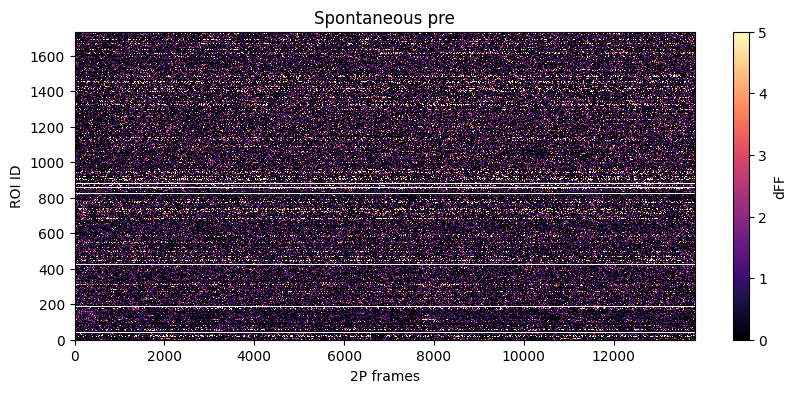

In [27]:
plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')

Text(0.5, 1.0, 'Spontaneous post')

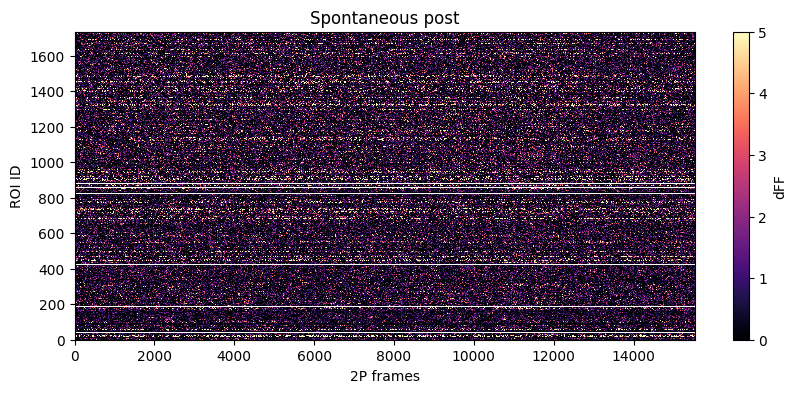

In [28]:
plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Woah thats a lot of ROIs. Are they all valid? 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image segmentation ROI masks
    
The ROI table contains the output of suite2P segmentation for this imaging plane. depending on the parameters used in data processing, suite2P can pick up a lot of ROIs or just a few. The probability of ROIs being a soma or dendrite are provided and can be used to filter for valid soma ROIs. 
    
Here is what the columns of the ROI table mean:

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Filter ROIs to limit data to high probability cell somas. 
    
Load the image segmentation masks from the *<b>data_interfaces</b>* container within the *<b>processing</b>* container. 

Turn the `roi_table` into a dataframe and check the columns.

</div>

In [29]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Use a `soma_probability` threshold of 0.5 and get the coresponding ROI ids. 

Filter your dff traces arrays for the pre and post spontaneous periods to limit to these ROI ids and plot the heatmaps again. 

</div>

In [30]:
valid_rois = image_segmentation[image_segmentation.soma_probability>0.5].index.values
print('there are', len(valid_rois), 'ROIs with soma_probability > 0.5')

there are 108 ROIs with soma_probability > 0.5


In [31]:
dff_pre = dff_pre[valid_rois, :]
print(dff_pre.shape)

(108, 13799)


In [32]:
dff_post = dff_post[valid_rois, :]
print(dff_pre.shape)

(108, 13799)


Text(0.5, 1.0, 'Spontaneous pre')

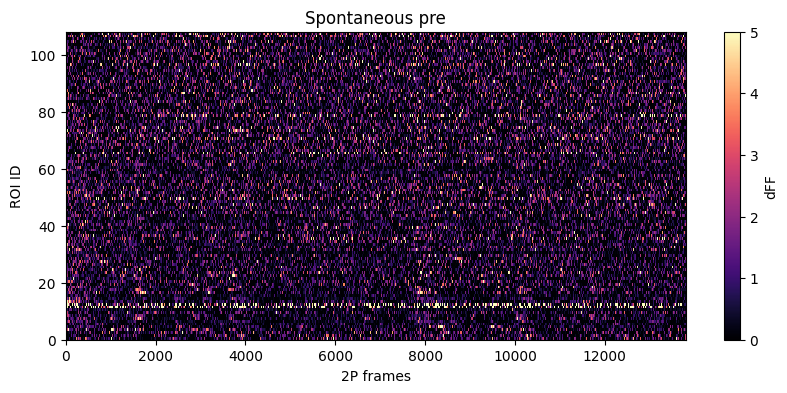

In [33]:
plt.pcolormesh(dff_pre, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous pre')

Text(0.5, 1.0, 'Spontaneous post')

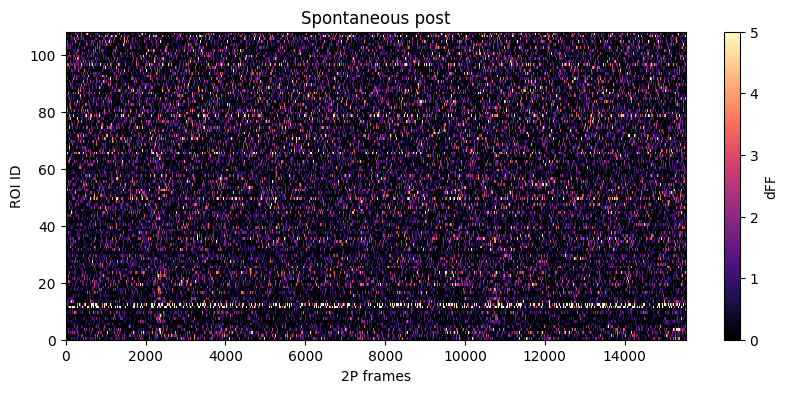

In [34]:
plt.pcolormesh(dff_post, vmin=0, vmax=5, cmap='magma')
plt.colorbar(label='dFF')
plt.xlabel('2P frames')
plt.ylabel('ROI ID')
plt.title('Spontaneous post')

Just show how to filter the ROIs, dont make it an exercise.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Quantifying correlations
    
Correlations between neuron activity traces could indicate a direct connection between them, or more likely indicates that they received shared input and are part of an interacting network. Let's compute the pairwise correlations between all the neurons and compare them for pre and post spontaneous periods. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Quantify the correlation between every cell pair's dff traces for the pre and post spontaneous periods and plot each as a heatmap. Dont forget to label your axes and include a title so you remember which is pre and which is post. 
    
Hint: Use [np.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) to do this. 

</div>

In [35]:
correlations_pre = np.corrcoef(dff_pre)
correlations_post = np.corrcoef(dff_post)

correlations_pre.shape

(108, 108)

(np.float64(0.0), np.float64(108.0), np.float64(0.0), np.float64(108.0))

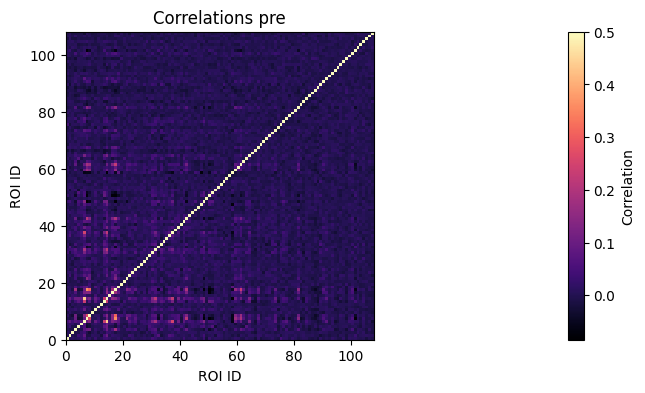

In [36]:
plt.pcolormesh(correlations_pre, cmap='magma', vmax=0.5)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations pre')
plt.axis('square')

(np.float64(0.0), np.float64(108.0), np.float64(0.0), np.float64(108.0))

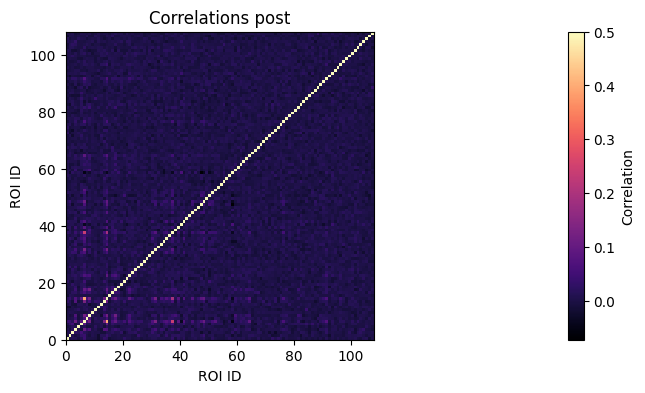

In [37]:
plt.pcolormesh(correlations_post, cmap='magma', vmax=0.5)
plt.colorbar(label='Correlation')
plt.xlabel('ROI ID')
plt.ylabel('ROI ID')
plt.title('Correlations post')
plt.axis('square')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Plot the distribution of correlation values as histogram comparing pre and post. 
    
Hint 1: Make sure to flatten your matrix into a 1D array to plot the histogram. 
    
Hint 1: Use histtype='step' as an argument to plt.hist to be able to more easily view the results.
    
Do a t-test with [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) - are the distributions statistically different? include the p-value in the plot title
    
</div>

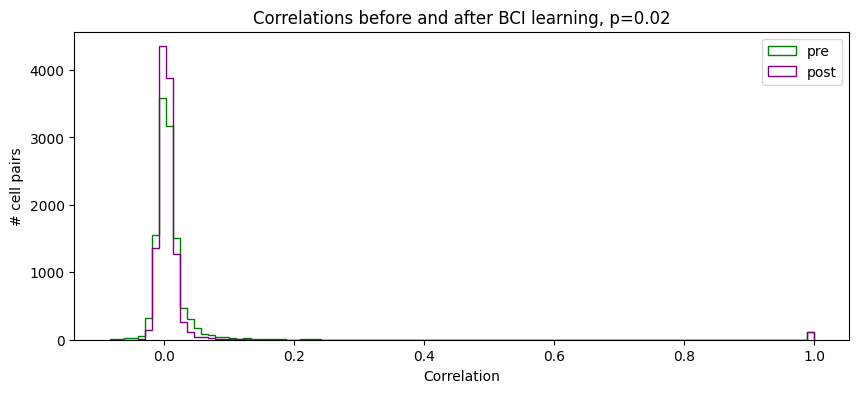

In [38]:
t, p_val = stats.ttest_ind(correlations_pre.flatten(), correlations_post.flatten())

plt.hist(correlations_pre.flatten(), bins=100, color='green', label='pre', histtype='step')
plt.hist(correlations_post.flatten(), bins=100, color='purple', label='post', histtype='step')
plt.title('Correlations before and after BCI learning, p='+str(np.round(p_val, 3)))
plt.xlabel('Correlation')
plt.ylabel('# cell pairs')
plt.legend()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Part 4: Do correlations depend on distance between neurons?</h2>
    - Segmented ROI masks and spatial relationships


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### ROI Image Masks 
    
ROI masks are extracted from the ophys data to identify regions corresponding to cells and dendrites. Here we want to identify the ROIs correspoding to the cells we computed correlations for earlier and quantify how the distance between ROIs relates to their correlations. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Get the `roi_table` from the from the *<b>data_interfaces</b>* container within the *<b>processing</b>* container and limit it to ROIs with `soma_probability` > 0.5 like we did earlier for the dF/F traces. 
    
Plot the `image_mask` for one of the ROIs. 

In [39]:
# In case you forgot how to find the roi_table
roi_table = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
# Limit to real somas
roi_table = roi_table[roi_table['soma_probability']>0.5]

Text(0.5, 1.0, 'ROI Image Mask')

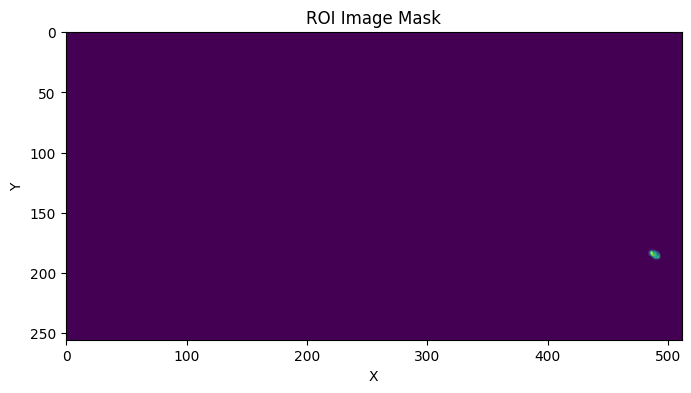

In [40]:
# Plot the image mask for selected ROI 
ROI = 10
plt.imshow(roi_table.image_mask[ROI])
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('ROI Image Mask') 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Calculate the centroid of each ROI image mask 

The ROI image masks are represented as a HxW sparse array with non-zero values that span the ROI area. We can find the centroid of the ROI by calculating the mean of the x,y indices of each mask. We've pre-written the function `get_roi_centroids` to do this. 

In [41]:
def get_roi_centroids(roi_table):
    centroids = []
    for mask in roi_table['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

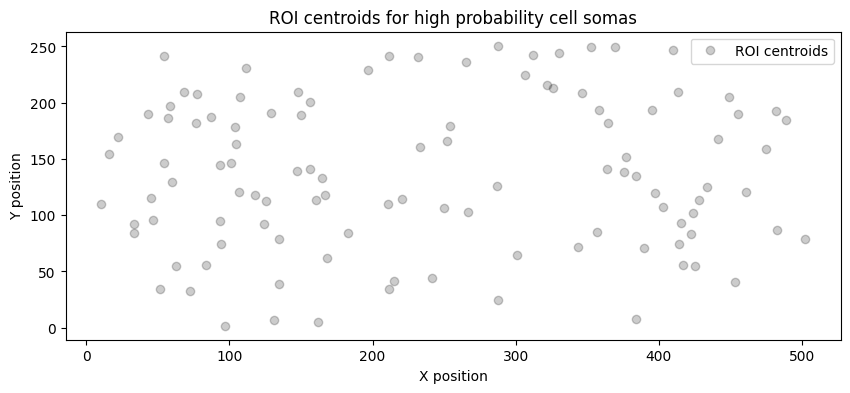

In [42]:
# Calculate centroids for each ROI and plot 

centroids = get_roi_centroids(roi_table)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.xlabel('X position') 
plt.ylabel('Y position')
plt.title('ROI centroids for high probability cell somas')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Calculate the distance between one pair of cells using [math.dist](https://docs.python.org/3/library/math.html#math.dist)


In [43]:
import math

In [44]:
centroid_cell_1 = centroids[0, :]
centroid_cell_2 = centroids[1, :]

math.dist(centroid_cell_1, centroid_cell_2)

383.22641299927886

## Turn the below thing into a demo not exercise

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

**Exercise:** Create a table that contains a row for each cell pair, with columns for each cell index, their correlation pre and post, and the distance between them.


In [45]:
pairs_data = []
for roi_id_1 in range(len(roi_table.index.values)): 
    for roi_id_2 in range(len(roi_table.index.values)): 
        centroid_cell_1 = centroids[roi_id_1, :]
        centroid_cell_2 = centroids[roi_id_2, :]
        distance = math.dist(centroid_cell_1, centroid_cell_2)
        r_value_pre = correlations_pre[roi_id_1, roi_id_2]
        r_value_post = correlations_post[roi_id_1, roi_id_2]
        pairs_data.append([roi_id_1, roi_id_2, r_value_pre, r_value_post, distance])


In [46]:
pairs = pd.DataFrame(pairs_data, columns=['roi_id_1', 'roi_id_2', 'r_value_pre', 'r_value_post', 'distance'])
pairs.head()

,roi_id_1,roi_id_2,r_value_pre,r_value_post,distance
0,0,0,1.000000,1.000000,0.000000
1,0,1,0.005718,-0.000360,383.226413
2,0,2,0.009467,0.009913,318.782584
3,0,3,0.000078,0.006815,52.279121
4,0,4,0.011094,-0.005914,171.370694


Text(0.5, 1.0, 'Activity correlation as a function of distance for cell pairs')

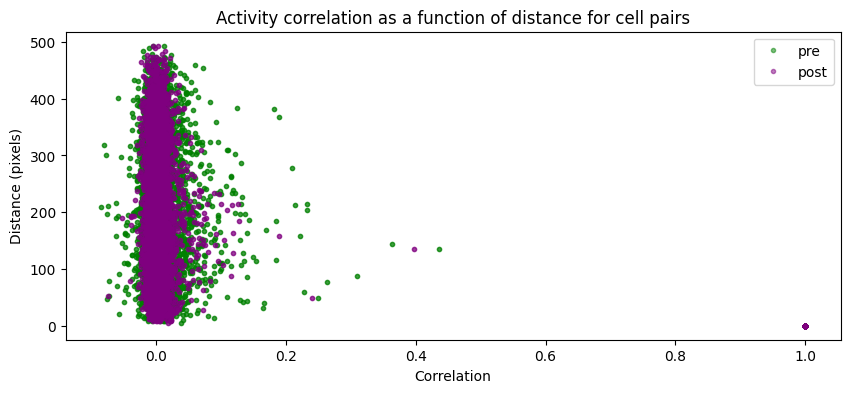

In [47]:
plt.plot(pairs.r_value_pre.values, pairs.distance.values, '.', color='green', label='pre', alpha=0.5)
plt.plot(pairs.r_value_post.values, pairs.distance.values, '.', color='purple', label='post', alpha=0.5)
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Distance (pixels)')
plt.title('Activity correlation as a function of distance for cell pairs')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">

#### Questions and analyses to explore further:
 
* How does connectivity change across the photostimulation periods? 
        
* Do correlated neurons tend to have stronger connections? 
    
* Quantify the degree to which the conditioned neuron increases its activity throughout the task. 
    
* Do differences in the transgenic lines or injected viruses impact connectivity and photostimulation measurements? 
    
* Do non-conditioned neurons change activity during the BCI task? 
    